<a href="https://colab.research.google.com/github/angelfox4/Pytorch_Introduction/blob/main/MNIST_%EC%86%8C%ED%94%84%ED%8A%B8%EB%A7%A5%EC%8A%A4_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

GPU 설정

In [ ]:
USE_CUDA=torch.cuda.is_available()
device=torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다.", device)

다음 기기로 학습합니다. cuda


랜덤 시드 고정+하이퍼파라미터 설정

In [ ]:
#for reproducibility
random.seed(777)
torch.manual_seed(777)
if device =='cuda':
  torch.cuda.manual_seed_all(777)

In [ ]:
# hyperparameters
training_epochs=15
batch_size=100

## MNIST 분류기 구현하기

MNIST dataset 다운로드 및 가져오기

In [ ]:
#MNIST dataset
mnist_train=dsets.MNIST(root='MNIST_data/', train=True, transform=transforms.ToTensor(), download=True)
mnist_test=dsets.MNIST(root="MNIST_data/", train=False, transform=transforms.ToTensor(), download=True)

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


dataset 미니배치로 나누기  
drop_last를 하는 이유는 다른 미니 배치보다 개수가 적은 마지막 배치를 경사 하강법에 사용해 마지막 배치가 상대적으로 과대 평가되는 현상을 막아준다.  


In [ ]:
#dataset loadeer
data_loader=DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)

모델을 설계

In [ ]:
#MNIST data image of shape 28*28=784
#input_dim=784, output_dim=10
linear=nn.Linear(784, 10, bias=True).to(device) #to() 함수는 연산을 어디서 수행할지를 정함. cpu일 경우 필요없음

#비용함수와 옵티마이저 정의
criterion=nn.CrossEntropyLoss().to(device) #내부적으로 소프트맥스 함수를 포함하고 있음
optimizer=torch.optim.SGD(linear.parameters(), lr=0.01)

In [ ]:
for epoch in range(training_epochs): #앞서 training_epochs의 값은 15로 지정함
  avg_cost=0
  total_batch=len(data_loader)

  for X, Y in data_loader:
    #배치 크기가 100이므로 아래의 연산에서 X는 (100, 784)의 텐서가 됨
    X=X.view(-1, 28*28).to(device)
    #레이블은 원-핫 인코딩이 된 상태가 아니라 0~9의 정수
    Y=Y.to(device)

    optimizer.zero_grad()
    hypothesis=linear(X)
    cost=criterion(hypothesis, Y)
    cost.backward()
    optimizer.step()

    avg_cost += cost/total_batch

  print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')





Epoch: 0001 cost = 0.318520159
Epoch: 0002 cost = 0.317111671
Epoch: 0003 cost = 0.315896988
Epoch: 0004 cost = 0.314619362
Epoch: 0005 cost = 0.313493162
Epoch: 0006 cost = 0.312337309
Epoch: 0007 cost = 0.311264396
Epoch: 0008 cost = 0.310221672
Epoch: 0009 cost = 0.309222132
Epoch: 0010 cost = 0.308254510
Epoch: 0011 cost = 0.307320535
Epoch: 0012 cost = 0.306453735
Epoch: 0013 cost = 0.305575907
Epoch: 0014 cost = 0.304763794
Epoch: 0015 cost = 0.303928345
Learning finished


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.9021999835968018
Label : 7
Prediction : 7


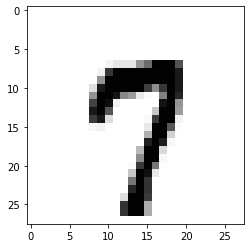

In [ ]:
with torch.no_grad(): # torch.no_grad()를 하면 gradient 계산을 수행하지 않음
  X_test=mnist_test.test_data.view(-1, 28*28).float().to(device)
  Y_test=mnist_test.test_labels.to(device)

  prediction=linear(X_test)
  correct_prediction=torch.argmax(prediction, 1)==Y_test
  accuracy=correct_prediction.float().mean()
  print("Accuracy:", accuracy.item())

  #MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측을 해본다.
  r=random.randint(0, len(mnist_test)-1)
  X_single_data=mnist_test.test_data[r:r+1].view(-1, 28*28).float().to(device)
  Y_single_data=mnist_test.test_labels[r:r+1].to(device)

  print('Label :', Y_single_data.item())
  single_prediction=linear(X_single_data)
  print("Prediction :", torch.argmax(single_prediction, 1).item())

  plt.imshow(mnist_test.test_data[r:r+1].view(28, 28), cmap='Greys', interpolation='nearest')
  plt.show()